# Drake Passage Transport

This notebook calculates and plots a timeseries of Drake Passage transport and the barotropic stremfunction over the final year of each experiment.

In [11]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm

In [3]:
db='/g/data/x77/amh157/PanAnt/panant.db'
session=cc.database.create_session(db)
expts = ['panant-v2','panant-hycom1']

## Drake Passage Timeseries

Uses barotropic flow through 71°W.

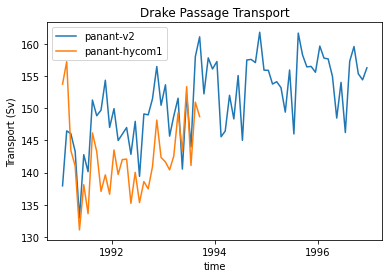

In [4]:
for expt in expts:
    umo_2d = cc.querying.getvar(expt,'umo_2d', session)
    DP = umo_2d.sel(xq=-71,method='nearest').sum('yh')/1e9
    DP.plot(label=expt)
    
plt.title('Drake Passage Transport')
plt.ylabel('Transport (Sv)')
plt.legend()

# Barotropic streamfunction maps

These are currently calculated over the final year of each experiment.

In [5]:
depth = cc.querying.getvar('panant-v2','deptho',session,n=1)
land_mask = np.squeeze(depth.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

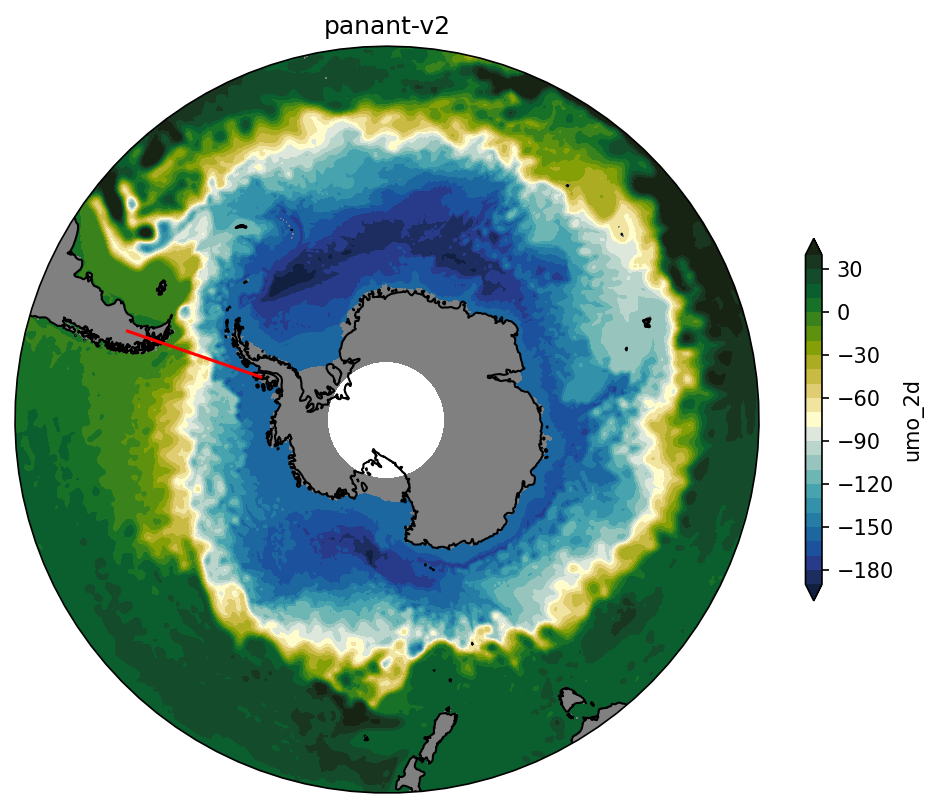

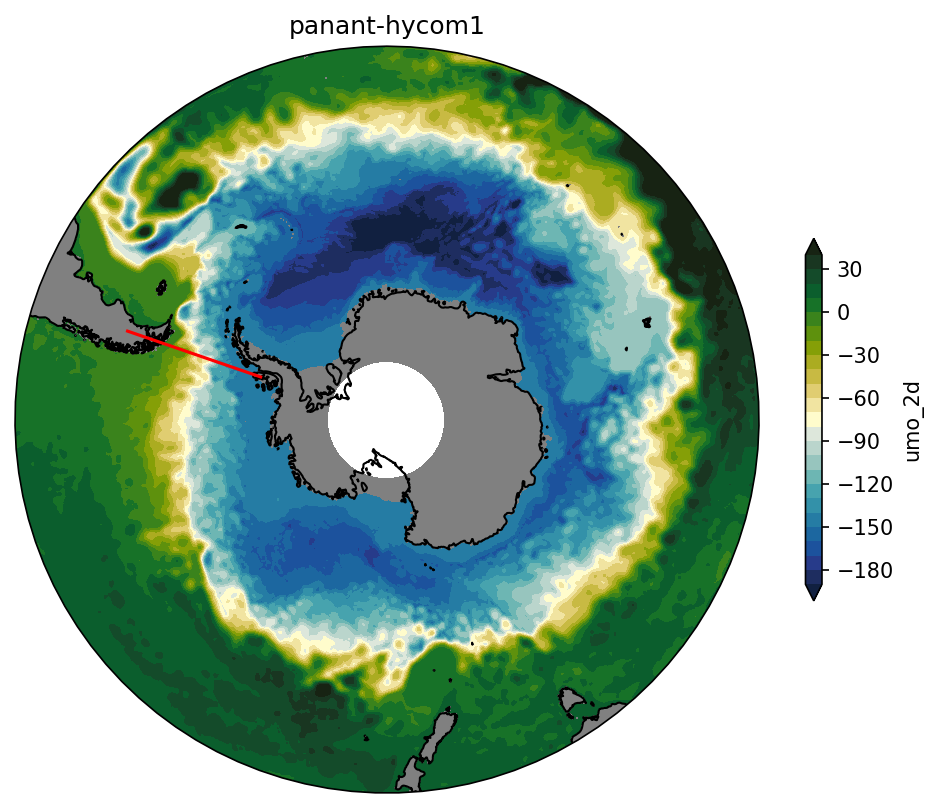

In [16]:
projection=ccrs.SouthPolarStereo()
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

for expt in expts:
    umo_2d = cc.querying.getvar(expt,'umo_2d', session)
    psi = umo_2d.isel(time=slice(-12,-1)).mean('time').cumsum('yh')/1e9
    psi = (psi - psi.sel(xq=-71,method='nearest').sel(yh=-40,method='nearest')).load()


    fig = plt.figure(figsize=(8, 8), dpi=150)
    ax = plt.subplot(1, 1, 1, projection=projection)
    psi.plot.contourf(ax=ax,levels=np.arange(-190,50,10),transform=ccrs.PlateCarree(),
                      cmap=cm.cm.delta,cbar_kwargs={'shrink': 0.4})
    ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')

    ax.coastlines(resolution='50m')
    ax.plot([-71,-71],[-70,-50],color='r',transform=ccrs.PlateCarree())
    ax.set_extent([-280, 80, -82, -37], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    plt.title(expt)